In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from sklearn.metrics import mean_squared_error

In [71]:
def plot(x, y, title="График", x_label="x", y_label="y", label=None):
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label, rotation=0)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_label_coords(1.05, 0)
    ax.yaxis.set_label_coords(0, 1.05)
    plt.grid(visible=True)
    #построение на плоскости
    plt.plot(x, y, label=label)

In [72]:
def sin(f):
    w=2*np.pi*f/100
    c=2*np.cos(w)
    y1=0
    y11=-np.sin(w)

    for i in range(100):
        y=c*y1-y11
        y11, y1=y1, y
        yield y

def sin_origin(f):
    x=np.linspace(0, 2*np.pi, 100)
    for elem in np.sin(f*x):
        yield elem

In [73]:
def double_interpolate(x, s):
    spline=CubicSpline(x, s)
    x1=np.linspace(min(x), max(x), len(x)*2)
    return x1, spline(x1)

In [74]:
def double_decematio(x, s):
    
    return x[0::2], s[0::2]

# График ошибки преобразований

max error of Algorithm`s sin: f_max= 38.0, max_error=0.16731172992795026
max error of Numpy sin: f_max= 37.5, max_error=0.16730118485128234


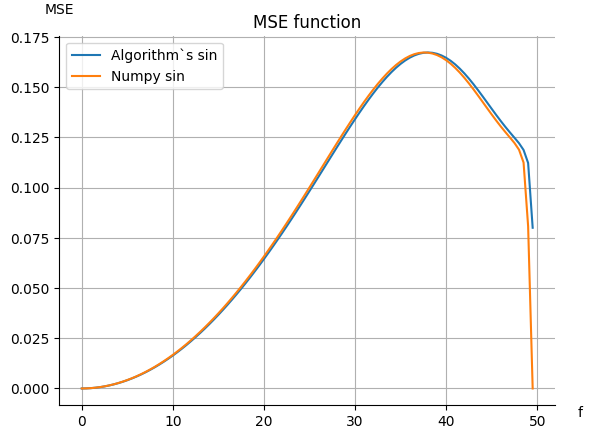

In [ ]:
def plot_error(func, label="Sin"):
    f_mass  =   [i for i in range(50)]
    sin_error=[]
    for f in f_mass:
        sin_signal=[x for x in func(f)]
        x=np.linspace(0, 2*np.pi, len(sin_signal))
        x, sin_new=double_interpolate(x, sin_signal)
        x, sin_new=double_decematio(x, sin_new)
        sin_error+=[mean_squared_error(sin_signal[:len(sin_new)], sin_new)]

    max_i=0
    for i in range(len(f_mass)):
        if sin_error[i]>sin_error[max_i]:
            max_i=i
    print(f"max error of {label}: f_max= {f_mass[max_i]}, max_error={sin_error[max_i]}")
    plot(f_mass, sin_error, title="MSE function", x_label="f", y_label="MSE", label=label)
    plt.legend()
    

plot_error(sin, label="Algorithm`s sin")
plot_error(sin_origin, label="Numpy sin")


# Случай наибольшей ошибки

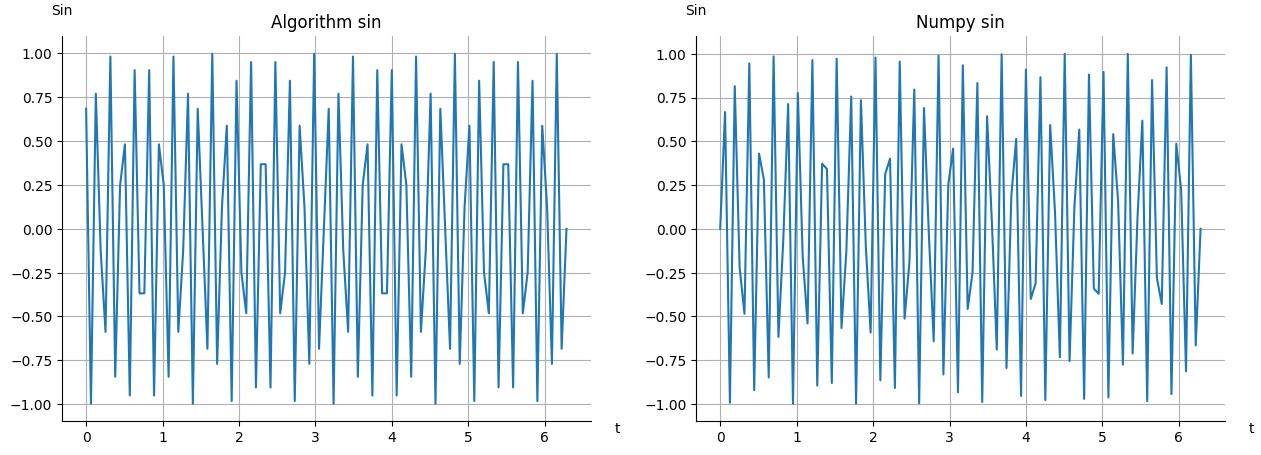

In [81]:
x=np.linspace(0, 2*np.pi, 100)
f=38
sin1=[i for i in sin(f)]
sin2=[i for i in sin_origin(f)]
method_err=[]
for i in range(100):
    method_err+=[abs(abs(sin1[i])-abs(sin2[i]))]

#plt.plot(x, method_err)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot(x, sin1, title="Algorithm sin", x_label="t", y_label="Sin")
plt.subplot(1, 2, 2)
plot(x, sin2, title="Numpy sin", x_label="t", y_label="Sin")

# Провал при f=50 Гц
Провал при f=50 Гц присутсвует из-за действия алгоритма, который определяет все начальные значения как 0 и в последствии копит вычислительную ошибку.
В случае синуса библиотеки он происходит из-за невыполнения теоремы Котельникова.

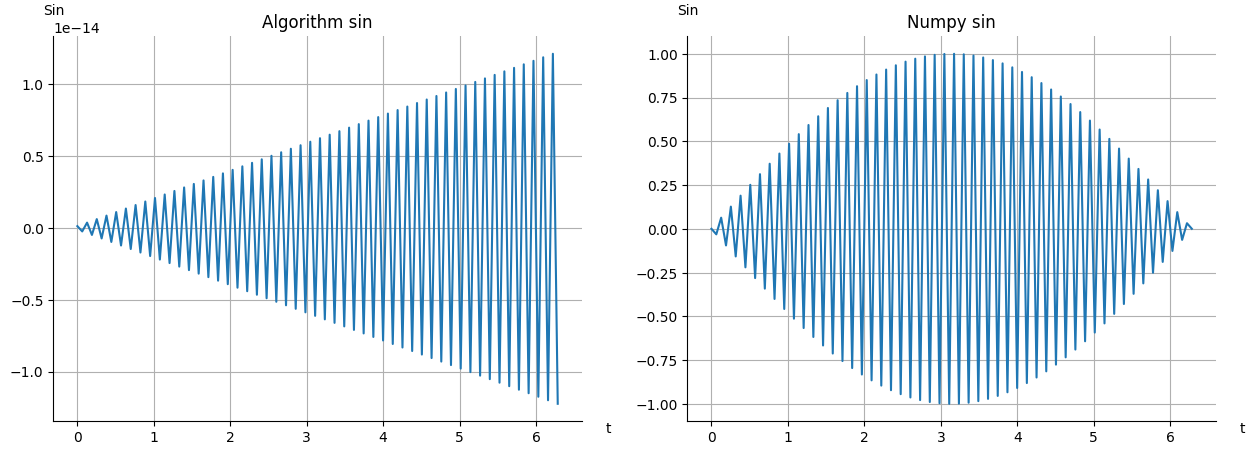

In [82]:
x=np.linspace(0, 2*np.pi, 100)
f=50
sin1=[i for i in sin(f)]
sin2=[i for i in sin_origin(f)]
method_err=[]
for i in range(100):
    method_err+=[abs(abs(sin1[i])-abs(sin2[i]))]

#plt.plot(x, method_err)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot(x, sin1, title="Algorithm sin", x_label="t", y_label="Sin")
plt.subplot(1, 2, 2)
plot(x, sin2, title="Numpy sin", x_label="t", y_label="Sin")

# Объяснение полученных рехультатов

In [78]:
%%latex

Чтобы понять причину получившейся ошибки, для начала стоит разобраться с исходным сигналом. 

Несмотря на то, что требуется использование синуса, на деле мы рассматриваем радиоимпульс. 
Поскольку сигнал конечен по времени, его спектр не ограничен по частоте. 
Поэтому нам необходимо рассмотреть некоторую ширину его спектра.

Сам сигнал представляет собой:
$$
s(t)=sin(ft) \cdot 1(t)_{[0, 2 \pi]}
$$
Спектр можно рассматривать как:
$$
S(\omega)=\pi(sinc(\pi(f-w))+sinc(\pi(f+w)))
$$
(Это спектр радиоимпульса. В нашем случае качественных отличий не будет.) 

Отсюда видно, что необходимо рассматривать ненулевую ширину спектра, как мы бы могли делать с дельта-функцией в случае бесконечности синуса.  

При дискретизации сигнала, его спектр "размножается" на частоты, кратные частоте дискретизации. Из-за этого высокие частоты накладываются на другие спектры.
На малых частотах исходного сигнала на спектры почти не приходит никаких искажений от соседних из-за убывающего характера $sinc(\omega)$. 

При изменении f исходного сигнала, спектр отдаляется от частот, кратных частоте дискретизации, тем самым взаимодействуя больше с соседними спектрами.
В какой-то момент влияние соседних импульсов друг на друга начинает приводить к необратимым изменениям в сигнале. 
По факту это свидетельствует о нарушении теоремы Котельникова. При росте f воздействие спектров друг на друга будет все сильнее, что будет увеличивать их искажения.

Интерполяция увеличивает расстояние между кратными частоте дискретизации частотами, тем самым и увеличивая расстояние и между соседними спектрами, а так же сжимает спектр сигналов. 
Поскольку исходный сигнал уже приобрел некоторые изменения в своей структуре из-за выше описанных явлений, интерполяция искажает сильнее и без того искаженный сигнал.

Действие децимации аналогично интерполяции, но наоборот уменьшает расстояние между спектрами и расширяет их. Из-за бесконечности спектров сигналов после интерполяции 
(хранимый сигнал конечный), они тоже будут влиять на близлежащие спектры. Поэтому высокие частоты спектров при децимации будут плохо воздействовать на качество сигнала.

В итоге можно сказать, что ошибка такая, поскольку при увеличении частоты сигнала влияние соседних спектров друг на друга увеличивается, а интерполяция и децимация их усиливает.

<IPython.core.display.Latex object>